It worth to notice that there is a discrepancy here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle
import os
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras import regularizers

Using TensorFlow backend.


In [2]:
from models import *

In [3]:
from gen_train_test_data import *
from simtools import *
%load_ext autoreload
%autoreload 2

# load scaler        
with open("model/scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        scaler=pickle.load(f)

In [4]:
date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]

In [5]:
## Global Constants

In [6]:
ticker="TSLA"

time_steps = 50

In [7]:
round_lot = 1

## Load Models

In [8]:
import os
import re

model_list = os.listdir("model/")
model_list = [s for s in model_list if ((re.search(r'scaler', s) is None) and (re.search(r'[a-zA-Z0-9]*\.p', s)))]

print(model_list)

['GradientBoost_20190102_20190115.p', 'RandomForest_20190102_20190115.p', 'CNN_20190102_20190115.p', 'XGBoost_20190102_20190115.p', 'LSTM_20190102_20190115.p', 'CNN1d_20190102_20190115.p']


## Model Prediction

Added penalty to the last minute order

In [9]:
###### VWAP price is penalized for last min order ######
last_min_penalty = 100.

In [10]:
import vwap2 as vw
matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]


In [11]:
def test_vwap(day, order_quantity, order_side, schedule_coef = 0.0, tick_coef = 0., model_coef = 1.,model=True):
    results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs, last_min_penalty = last_min_penalty, round_lot = round_lot, schedule_coef = schedule_coef,\
                           tick_coef = tick_coef, model_coef = model_coef, using_model=model)
    display_result(results,False)
    return results

def display_result(results,plot=True):
    data = results['trades']
    if plot:
        print("FV and midpoints:")
        plt.plot(results['fair_values'].index,results['fair_values'].values,color='r')
        plt.plot(results['midpoints'].index,results['midpoints'].values,color='r')
        plt.legend(["fair_values","midpoints"])
        plt.show()
        print("Trade prices:")
        plt.plot(data.price.index,data.price.values,color=taolaoshi[0])
        plt.show()
    print("percentage of aggressive order:",np.mean(data['trade_type']=="a"))
    print("last_min_order:",results['last_min_order'])
    print("avg price:",results['avg_price'])
    print("day_vwap price:",results['day_vwap'])
    print("avg - day_vwap:",results['avg_price'] - results['day_vwap'])

In [12]:
def model_vwap_evaluation(model, schedule_coef_b, schedule_coef_s, tick_coef, model_coef):
    for date in test_date_list:
        if not os.path.exists("test_result/x_test_{}.p".format(date)):
            x,idx=create_test_dataset(ticker=ticker,time_steps = time_steps, input_scaler=scaler, date=date)
            print(x.shape,idx.shape)
            with open("test_result/x_test_{}.p".format(date),"wb") as f:
                    pickle.dump(x,f)
        
        x = None
        with open("test_result/x_test_{}.p".format(date),"rb") as f:
            x = pickle.load(f)
        
        # Using Model for Prediction
        signal=model.predict(x[:,:, 1:])
        with open("test_result/signal_test_{}.p".format(date),"wb") as f:
                pickle.dump(signal,f)
        
        log_message( "{} finished".format(date) )

    test_taq=dict()

    for date in test_date_list:
        if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):

            with open("test_result/signal_test_{}.p".format(date),"rb") as f:
                signal=pickle.load(f)
            #print(signal[-100:])

            # generate signal and attach it to original df
            if len(signal.shape) > 1:
                signal_discrete=signal.argmax(axis=1)-1
            else:
                signal_discrete=signal
            #signal_continuous=np.dot(signal,np.array([[-1],[0],[1]])).ravel()

            trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
            N=len(trades)

            signal_discrete=np.concatenate((np.zeros(N-len(signal_discrete))+np.nan,signal_discrete), axis=0)
            trades[["signal_discrete"]]=pd.DataFrame({"signal_discrete":signal_discrete,},index=trades.index)

            # merge TAQ
            quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
            taq=makeTAQfile(trades, quotes)
            test_taq[date]=taq

            log_message( "{} finished".format(date) )
    i=0

    results_s = {'midpoints': [],
                 'fair_values': [],
                 'schedule_factors': [],
                 'tick_factors': [],
                 'model_factors': [],
                 'trades': [],
                 'quote_count': [],
                 'day_vwap': [],
                 'avg_price': [],
                 'avg_spread': [],
                 'last_min_order': [],
                }
    results_b = {'midpoints': [],
                 'fair_values': [],
                 'schedule_factors': [],
                 'tick_factors': [],
                 'model_factors': [],
                 'trades': [],
                 'quote_count': [],
                 'day_vwap': [],
                 'avg_price': [],
                 'avg_spread': [],
                 'last_min_order': [],
                }


    for date in test_taq.keys():
        print("-------------------------------------------------------------------------------------------------")
        day=test_taq[date]
        #print("----------------Tick-----------------")
        #r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 1., LSTM_coef = 0.,LSTM=False)
        print("----------------{}-----------------".format(model.model_name))
        print("Date: ", date)
        # Model Coef:
        # buy: if the next step is 1, predicted price increase, then fair value should increase, inclined to buy now, so model_coef = 1
        # sell: if the next step is 1, predicted price increase, then fair value should increase, inclined to wai now, so model_coef = 1
        
        # Schedule Coef:
        # buy: if fall behind, factor positive, then to encourage buy, then fair value should increase, inclined to buy now, so model_coef = 1
        # sell: if fall behind, factor positive, then to encourage sell, then fair value should decrease, inclined to buy now, so model_coef = -1
        r_model_b=test_vwap(day, order_quantity=300000, order_side="b", schedule_coef = schedule_coef_b, tick_coef = tick_coef, model_coef = model_coef, model=True)
        r_model_s=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = schedule_coef_s, tick_coef = tick_coef, model_coef = model_coef, model=True)
        

        results_s['midpoints'].append(r_model_s['midpoints'])
        results_s['fair_values'].append(r_model_s['fair_values'])
        results_s['schedule_factors'].append(r_model_s['schedule_factors'])
        results_s['tick_factors'].append(r_model_s['tick_factors'])
        results_s['model_factors'].append(r_model_s['model_factors'])
        results_s['trades'].append(r_model_s['trades'])
        results_s['quote_count'].append(r_model_s['quote_count'])
        results_s['day_vwap'].append(r_model_s['day_vwap'])
        results_s['avg_price'].append(r_model_s['avg_price'])
        results_s['avg_spread'].append(r_model_s['avg_spread'])
        results_s['last_min_order'].append(r_model_s['last_min_order'])
        
        results_b['midpoints'].append(r_model_b['midpoints'])
        results_b['fair_values'].append(r_model_b['fair_values'])
        results_b['schedule_factors'].append(r_model_b['schedule_factors'])
        results_b['tick_factors'].append(r_model_b['tick_factors'])
        results_b['model_factors'].append(r_model_b['model_factors'])
        results_b['trades'].append(r_model_b['trades'])
        results_b['quote_count'].append(r_model_b['quote_count'])
        results_b['day_vwap'].append(r_model_b['day_vwap'])
        results_b['avg_price'].append(r_model_b['avg_price'])
        results_b['avg_spread'].append(r_model_b['avg_spread'])
        results_b['last_min_order'].append(r_model_b['last_min_order'])

        log_message( "{} finished".format(date) )
    
    return (results_s, results_b)

# Running of each model

In [13]:
schedule_coef_b = 0.5
schedule_coef_s = -0.5
model_coef = 1.
tick_coef = 1.

## CNN

In [14]:
with open("model/CNN_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)

CNN


In [15]:
results_CNN_s, results_CNN_b = model_vwap_evaluation(model, schedule_coef_b = schedule_coef_b, schedule_coef_s = schedule_coef_s, tick_coef = 0.0, model_coef = model_coef)

2020-04-28 14:45:48:522115: 20190117 finished
2020-04-28 14:46:55:139877: 20190118 finished
2020-04-28 14:47:27:281737: 20190122 finished
2020-04-28 14:48:04:579632: 20190123 finished
2020-04-28 14:48:27:037715: 20190124 finished
2020-04-28 14:48:47:572012: 20190125 finished
2020-04-28 14:49:05:153395: 20190128 finished
2020-04-28 14:49:18:434976: 20190129 finished
2020-04-28 14:49:45:782207: 20190130 finished
2020-04-28 14:50:20:145479: 20190131 finished
2020-04-28 14:50:20:821474: start merge
2020-04-28 14:50:20:887094: end merge
2020-04-28 14:50:20:887300: 20190117 finished
2020-04-28 14:50:22:578498: start merge
2020-04-28 14:50:22:898113: end merge
2020-04-28 14:50:22:898394: 20190118 finished
2020-04-28 14:50:23:322563: start merge
2020-04-28 14:50:23:401796: end merge
2020-04-28 14:50:23:402331: 20190124 finished
2020-04-28 14:50:23:821579: start merge
2020-04-28 14:50:23:886518: end merge
2020-04-28 14:50:23:886688: 20190125 finished
2020-04-28 14:50:24:301226: start merge
2020

(1172, 4)
299713.0
       price  shares  bar trade_type
1167  296.32     5.0  386          p
1168  296.26  1071.0  386          a
1169  296.33    26.0  387          p
1170  296.30  1229.0  387          a
1171  296.35  1284.0  388          a
2020-04-28 15:08:01:674319: end simulation loop
2020-04-28 15:08:01:674942: order analytics
2020-04-28 15:08:01:679671: VWAP run complete.
percentage of aggressive order: 0.2804774083546462
last_min_order: 287.0
avg price: 293.3972225041321
day_vwap price: 293.3454132785871
avg - day_vwap: 0.051809225545014215
2020-04-28 15:08:01:695758: 20190128 finished
-------------------------------------------------------------------------------------------------
----------------CNN-----------------
Date:  20190129
2020-04-28 15:08:01:696557: Beginning VWAP run: b 300000 shares
2020-04-28 15:08:01:714070: starting main loop
(1148, 4)
299713.0
       price  shares  bar trade_type
1143  297.27   225.0  385          a
1144  297.44  1226.0  386          a
1145  297

## LSTM

In [16]:
with open("model/LSTM_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)
results_LSTM_s, results_LSTM_b = model_vwap_evaluation(model, schedule_coef_b = schedule_coef_b, schedule_coef_s = schedule_coef_s, tick_coef = 0.0, model_coef = model_coef)

LSTM
2020-04-28 15:18:26:813247: 20190117 finished
2020-04-28 15:20:52:768189: 20190118 finished
2020-04-28 15:22:04:474741: 20190122 finished
2020-04-28 15:23:21:834808: 20190123 finished
2020-04-28 15:24:09:502399: 20190124 finished
2020-04-28 15:24:53:839334: 20190125 finished
2020-04-28 15:25:33:050458: 20190128 finished
2020-04-28 15:26:01:800070: 20190129 finished
2020-04-28 15:26:57:711416: 20190130 finished
2020-04-28 15:28:06:386307: 20190131 finished
2020-04-28 15:28:06:533446: start merge
2020-04-28 15:28:06:570567: end merge
2020-04-28 15:28:06:571043: 20190117 finished
2020-04-28 15:28:07:536028: start merge
2020-04-28 15:28:07:767062: end merge
2020-04-28 15:28:07:767665: 20190118 finished
2020-04-28 15:28:08:071738: start merge
2020-04-28 15:28:08:142428: end merge
2020-04-28 15:28:08:142936: 20190124 finished
2020-04-28 15:28:08:423384: start merge
2020-04-28 15:28:08:486072: end merge
2020-04-28 15:28:08:486569: 20190125 finished
2020-04-28 15:28:08:725871: start merge

(1184, 4)
299713.0
       price  shares  bar trade_type
1179  296.33    26.0  387          p
1180  296.33     4.0  387          p
1181  296.33     9.0  387          p
1182  296.30  1216.0  387          a
1183  296.35  1284.0  388          a
2020-04-28 15:45:23:533397: end simulation loop
2020-04-28 15:45:23:534004: order analytics
2020-04-28 15:45:23:538567: VWAP run complete.
percentage of aggressive order: 0.2776371308016878
last_min_order: 287.0
avg price: 293.39527793746544
day_vwap price: 293.3454132785871
avg - day_vwap: 0.04986465887833447
2020-04-28 15:45:23:552557: 20190128 finished
-------------------------------------------------------------------------------------------------
----------------LSTM-----------------
Date:  20190129
2020-04-28 15:45:23:553473: Beginning VWAP run: b 300000 shares
2020-04-28 15:45:23:567473: starting main loop
(1171, 4)
299713.0
       price  shares  bar trade_type
1166  297.27   225.0  385          a
1167  297.44  1226.0  386          a
1168  29

## Random Forest

In [17]:
with open("model/RandomForest_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
results_RF_s, results_RF_b = model_vwap_evaluation(model, schedule_coef_b = schedule_coef_b, schedule_coef_s = schedule_coef_s, tick_coef = 0.0, model_coef = model_coef)

2020-04-28 15:55:23:625672: 20190117 finished
2020-04-28 15:55:37:236413: 20190118 finished
2020-04-28 15:55:43:604353: 20190122 finished
2020-04-28 15:55:50:789994: 20190123 finished
2020-04-28 15:55:55:144608: 20190124 finished
2020-04-28 15:55:59:132350: 20190125 finished
2020-04-28 15:56:02:679171: 20190128 finished
2020-04-28 15:56:05:275742: 20190129 finished
2020-04-28 15:56:10:673934: 20190130 finished
2020-04-28 15:56:17:322987: 20190131 finished
2020-04-28 15:56:17:468370: start merge
2020-04-28 15:56:17:505588: end merge
2020-04-28 15:56:17:506058: 20190117 finished
2020-04-28 15:56:18:433975: start merge
2020-04-28 15:56:18:661760: end merge
2020-04-28 15:56:18:662358: 20190118 finished
2020-04-28 15:56:18:956190: start merge
2020-04-28 15:56:19:023955: end merge
2020-04-28 15:56:19:024420: 20190124 finished
2020-04-28 15:56:19:278585: start merge
2020-04-28 15:56:19:338099: end merge
2020-04-28 15:56:19:338555: 20190125 finished
2020-04-28 15:56:19:566578: start merge
2020

(1161, 4)
299713.0
       price  shares  bar trade_type
1156  296.32     5.0  386          p
1157  296.26  1071.0  386          a
1158  296.33    26.0  387          p
1159  296.30  1229.0  387          a
1160  296.35  1284.0  388          a
2020-04-28 16:10:44:605575: end simulation loop
2020-04-28 16:10:44:605834: order analytics
2020-04-28 16:10:44:608931: VWAP run complete.
percentage of aggressive order: 0.2857142857142857
last_min_order: 287.0
avg price: 293.39624827079876
day_vwap price: 293.3454132785871
avg - day_vwap: 0.05083499221166221
2020-04-28 16:10:44:618013: 20190128 finished
-------------------------------------------------------------------------------------------------
----------------RandomForest-----------------
Date:  20190129
2020-04-28 16:10:44:619387: Beginning VWAP run: b 300000 shares
2020-04-28 16:10:44:627973: starting main loop
(1179, 4)
299713.0
       price  shares  bar trade_type
1174  297.44  1226.0  386          a
1175  297.19     1.0  387          p


## Gradient Boost

In [18]:
with open("model/GradientBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
results_GB_s, results_GB_b = model_vwap_evaluation(model, schedule_coef_b = schedule_coef_b, schedule_coef_s = schedule_coef_s, tick_coef = 0.0, model_coef = model_coef)

2020-04-28 16:15:55:593191: 20190117 finished
2020-04-28 16:16:01:919512: 20190118 finished
2020-04-28 16:16:04:586914: 20190122 finished
2020-04-28 16:16:07:543308: 20190123 finished
2020-04-28 16:16:09:316568: 20190124 finished
2020-04-28 16:16:10:943797: 20190125 finished
2020-04-28 16:16:12:395281: 20190128 finished
2020-04-28 16:16:13:434633: 20190129 finished
2020-04-28 16:16:15:596608: 20190130 finished
2020-04-28 16:16:18:267826: 20190131 finished
2020-04-28 16:16:18:355433: start merge
2020-04-28 16:16:18:383946: end merge
2020-04-28 16:16:18:384139: 20190117 finished
2020-04-28 16:16:18:948505: start merge
2020-04-28 16:16:19:101791: end merge
2020-04-28 16:16:19:101998: 20190118 finished
2020-04-28 16:16:19:289261: start merge
2020-04-28 16:16:19:340968: end merge
2020-04-28 16:16:19:341150: 20190124 finished
2020-04-28 16:16:19:504142: start merge
2020-04-28 16:16:19:549451: end merge
2020-04-28 16:16:19:549651: 20190125 finished
2020-04-28 16:16:19:690454: start merge
2020

(4901, 4)
299713.0
       price  shares  bar trade_type
4896  296.38   100.0  388          p
4897  296.38     2.0  388          p
4898  296.38   100.0  388          p
4899  296.31   100.0  388          p
4900  296.26   832.0  388          a
2020-04-28 16:25:22:626735: end simulation loop
2020-04-28 16:25:22:626935: order analytics
2020-04-28 16:25:22:632503: VWAP run complete.
percentage of aggressive order: 0.002039983680130559
last_min_order: 287.0
avg price: 293.4513133707988
day_vwap price: 293.3454132785871
avg - day_vwap: 0.10590009221169794
2020-04-28 16:25:22:641953: 20190128 finished
-------------------------------------------------------------------------------------------------
----------------GradientBoost-----------------
Date:  20190129
2020-04-28 16:25:22:642133: Beginning VWAP run: b 300000 shares
2020-04-28 16:25:22:651814: starting main loop
(562, 4)
299713.0
      price  shares  bar trade_type
557  297.27  1181.0  385          a
558  297.44  1226.0  386          a
55

## XGBoost

In [19]:
with open("model/XGBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
results_XGB_s, results_XGB_b = model_vwap_evaluation(model, schedule_coef_b = schedule_coef_b, schedule_coef_s = schedule_coef_s, tick_coef = 0.0, model_coef = model_coef)

2020-04-28 16:30:32:358462: 20190117 finished
2020-04-28 16:30:40:321066: 20190118 finished
2020-04-28 16:30:44:222833: 20190122 finished
2020-04-28 16:30:48:423766: 20190123 finished
2020-04-28 16:30:50:974296: 20190124 finished
2020-04-28 16:30:53:308878: 20190125 finished
2020-04-28 16:30:55:415003: 20190128 finished
2020-04-28 16:30:56:925357: 20190129 finished
2020-04-28 16:31:00:258444: 20190130 finished
2020-04-28 16:31:04:433007: 20190131 finished
2020-04-28 16:31:04:552172: start merge
2020-04-28 16:31:04:584836: end merge
2020-04-28 16:31:04:585047: 20190117 finished
2020-04-28 16:31:05:165260: start merge
2020-04-28 16:31:05:330513: end merge
2020-04-28 16:31:05:330711: 20190118 finished
2020-04-28 16:31:05:517617: start merge
2020-04-28 16:31:05:569469: end merge
2020-04-28 16:31:05:569670: 20190124 finished
2020-04-28 16:31:05:733270: start merge
2020-04-28 16:31:05:777735: end merge
2020-04-28 16:31:05:777917: 20190125 finished
2020-04-28 16:31:05:926603: start merge
2020

(4901, 4)
299713.0
       price  shares  bar trade_type
4896  296.38   100.0  388          p
4897  296.38     2.0  388          p
4898  296.38   100.0  388          p
4899  296.31   100.0  388          p
4900  296.26   832.0  388          a
2020-04-28 16:41:02:567407: end simulation loop
2020-04-28 16:41:02:567999: order analytics
2020-04-28 16:41:02:576756: VWAP run complete.
percentage of aggressive order: 0.002039983680130559
last_min_order: 287.0
avg price: 293.4513133707988
day_vwap price: 293.3454132785871
avg - day_vwap: 0.10590009221169794
2020-04-28 16:41:02:595015: 20190128 finished
-------------------------------------------------------------------------------------------------
----------------XGBoost-----------------
Date:  20190129
2020-04-28 16:41:02:595781: Beginning VWAP run: b 300000 shares
2020-04-28 16:41:02:609588: starting main loop
(547, 4)
299713.0
      price  shares  bar trade_type
542  297.27  1198.0  385          a
543  297.44  1226.0  386          a
544  297

## Tick Factor

In [20]:
test_taq=dict()

for date in test_date_list:
    if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):
        
        trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
        
        
        # merge TAQ
        quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
        taq=makeTAQfile(trades, quotes)
        print(taq.shape)
        test_taq[date]=taq
        
        log_message( "{} finished".format(date) )

2020-04-28 16:51:23:148077: start merge
2020-04-28 16:51:23:189792: end merge
(50301, 9)
2020-04-28 16:51:23:190510: 20190117 finished
2020-04-28 16:51:24:138133: start merge
2020-04-28 16:51:24:368294: end merge
(428445, 9)
2020-04-28 16:51:24:369184: 20190118 finished
2020-04-28 16:51:24:679007: start merge
2020-04-28 16:51:24:748589: end merge
(113260, 9)
2020-04-28 16:51:24:749359: 20190124 finished
2020-04-28 16:51:25:019264: start merge
2020-04-28 16:51:25:079596: end merge
(99211, 9)
2020-04-28 16:51:25:080349: 20190125 finished
2020-04-28 16:51:25:323184: start merge
2020-04-28 16:51:25:379488: end merge
(89710, 9)
2020-04-28 16:51:25:380189: 20190128 finished
2020-04-28 16:51:25:569990: start merge
2020-04-28 16:51:25:614149: end merge
(66041, 9)
2020-04-28 16:51:25:614844: 20190129 finished
2020-04-28 16:51:26:078743: start merge
2020-04-28 16:51:26:181867: end merge
(202140, 9)
2020-04-28 16:51:26:182580: 20190130 finished
2020-04-28 16:51:26:665473: start merge
2020-04-28 1

In [21]:
results_tick_s = {'midpoints': [],
                 'fair_values': [],
                 'schedule_factors': [],
                 'tick_factors': [],
                 'model_factors': [],
                 'trades': [],
                 'quote_count': [],
                 'day_vwap': [],
                 'avg_price': [],
                 'avg_spread': [],
                 'last_min_order': [],
                }
results_tick_b = {'midpoints': [],
             'fair_values': [],
             'schedule_factors': [],
             'tick_factors': [],
             'model_factors': [],
             'trades': [],
             'quote_count': [],
             'day_vwap': [],
             'avg_price': [],
             'avg_spread': [],
             'last_min_order': [],
            }


for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    print("----------------Tick-----------------")
    print("Date: ", date)
    # Schedule Coef:
    # buy: if fall behind, factor positive, then to encourage buy, then fair value should increase, inclined to buy now, so model_coef = 1
    # sell: if fall behind, factor positive, then to encourage sell, then fair value should decrease, inclined to buy now, so model_coef = -1
    r_model_b=test_vwap(day, order_quantity=300000, order_side="b", schedule_coef = schedule_coef_b, tick_coef = tick_coef, model_coef = 0., model=False)
    r_model_s=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = schedule_coef_s, tick_coef = tick_coef, model_coef = 0., model=False)


    results_tick_s['midpoints'].append(r_model_s['midpoints'])
    results_tick_s['fair_values'].append(r_model_s['fair_values'])
    results_tick_s['schedule_factors'].append(r_model_s['schedule_factors'])
    results_tick_s['tick_factors'].append(r_model_s['tick_factors'])
    results_tick_s['model_factors'].append(r_model_s['model_factors'])
    results_tick_s['trades'].append(r_model_s['trades'])
    results_tick_s['quote_count'].append(r_model_s['quote_count'])
    results_tick_s['day_vwap'].append(r_model_s['day_vwap'])
    results_tick_s['avg_price'].append(r_model_s['avg_price'])
    results_tick_s['avg_spread'].append(r_model_s['avg_spread'])
    results_tick_s['last_min_order'].append(r_model_s['last_min_order'])

    results_tick_b['midpoints'].append(r_model_b['midpoints'])
    results_tick_b['fair_values'].append(r_model_b['fair_values'])
    results_tick_b['schedule_factors'].append(r_model_b['schedule_factors'])
    results_tick_b['tick_factors'].append(r_model_b['tick_factors'])
    results_tick_b['model_factors'].append(r_model_b['model_factors'])
    results_tick_b['trades'].append(r_model_b['trades'])
    results_tick_b['quote_count'].append(r_model_b['quote_count'])
    results_tick_b['day_vwap'].append(r_model_b['day_vwap'])
    results_tick_b['avg_price'].append(r_model_b['avg_price'])
    results_tick_b['avg_spread'].append(r_model_b['avg_spread'])
    results_tick_b['last_min_order'].append(r_model_b['last_min_order'])

    log_message( "{} finished".format(date) )

-------------------------------------------------------------------------------------------------
----------------Tick-----------------
Date:  20190117
2020-04-28 16:51:26:860252: Beginning VWAP run: b 300000 shares
2020-04-28 16:51:26:874853: starting main loop
(2830, 4)
299713.0
       price  shares  bar trade_type
2825  347.33    82.0  388          p
2826  347.33   118.0  388          p
2827  347.33    82.0  388          p
2828  347.33   118.0  388          p
2829  347.33    39.0  388          p
2020-04-28 16:51:58:362525: end simulation loop
2020-04-28 16:51:58:363645: order analytics
2020-04-28 16:51:58:369433: VWAP run complete.
percentage of aggressive order: 0.03638290356764394
last_min_order: 287.0
avg price: 347.4172410528206
day_vwap price: 347.7609699903627
avg - day_vwap: -0.343728937542096
2020-04-28 16:51:58:377717: Beginning VWAP run: s 300000 shares
2020-04-28 16:51:58:385103: starting main loop
(2933, 4)
299713.0
       price  shares  bar trade_type
2928  347.29  1255

(3566, 4)
299713.0
       price  shares  bar trade_type
3561  297.30    55.0  387          p
3562  297.30     1.0  387          p
3563  297.21  1189.0  387          a
3564  296.93     5.0  388          p
3565  296.84  1279.0  388          a
2020-04-28 17:09:01:261866: end simulation loop
2020-04-28 17:09:01:264351: order analytics
2020-04-28 17:09:01:271415: VWAP run complete.
percentage of aggressive order: 0.020745724698626296
last_min_order: 287.0
avg price: 295.61892665208893
day_vwap price: 295.61633583089167
avg - day_vwap: 0.0025908211972591744
2020-04-28 17:09:01:282284: 20190129 finished
-------------------------------------------------------------------------------------------------
----------------Tick-----------------
Date:  20190130
2020-04-28 17:09:01:283092: Beginning VWAP run: b 300000 shares
2020-04-28 17:09:01:323339: starting main loop
(3220, 4)
299713.0
       price  shares  bar trade_type
3215  308.10    52.0  386          p
3216  308.10     7.0  386          p
321

# Comparison of Models

Text(0.5, 1.0, 'Model Factors vs Tick Factor, Sell')

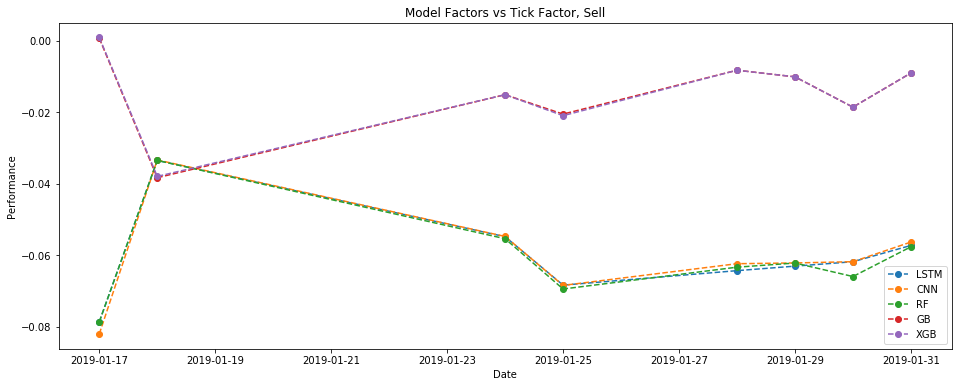

In [22]:
df_compare=pd.DataFrame({"Tick factor":results_tick_s['avg_price'],
                         "LSTM factor":results_LSTM_s['avg_price'],
                         "CNN factor":results_CNN_s['avg_price'],
                         "RandomForest factor":results_RF_s['avg_price'],
                         "GradientBoost factor":results_GB_s['avg_price'],
                         "XGBoost factor":results_XGB_s['avg_price'],
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])
plt.xlabel("Date") 
plt.ylabel("Performance")
plt.title("Model Factors vs Tick Factor, Sell")

Text(0.5, 1.0, 'Model Factors vs Tick Factor, Buy')

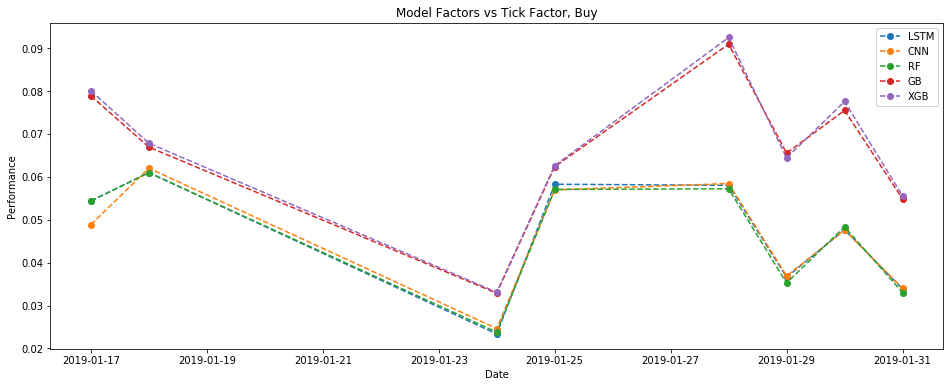

In [23]:
df_compare=pd.DataFrame({"Tick factor":results_tick_b['avg_price'],
                         "LSTM factor":results_LSTM_b['avg_price'],
                         "CNN factor":results_CNN_b['avg_price'],
                         "RandomForest factor":results_RF_b['avg_price'],
                         "GradientBoost factor":results_GB_b['avg_price'],
                         "XGBoost factor":results_XGB_b['avg_price'],
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])
plt.xlabel("Date") 
plt.ylabel("Performance")
plt.title("Model Factors vs Tick Factor, Buy")

## Last Minute Order

Text(0.5, 1.0, 'Model Factors vs Tick Factor, Sell')

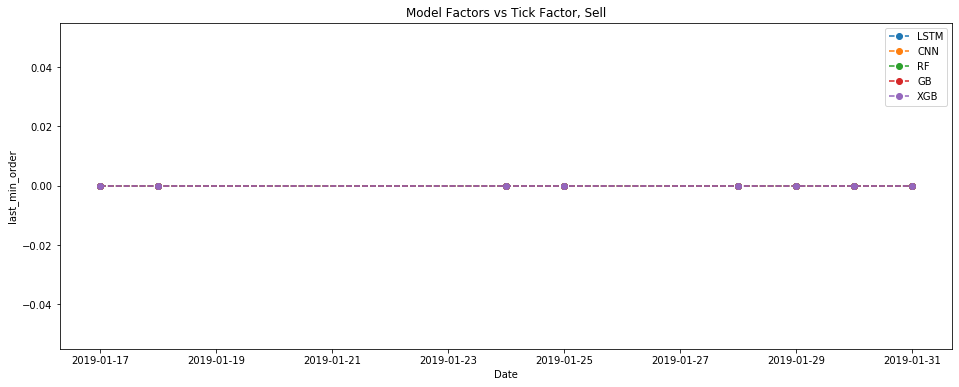

In [24]:
df_compare=pd.DataFrame({"Tick factor":results_tick_s['last_min_order'],
                         "LSTM factor":results_LSTM_s['last_min_order'],
                         "CNN factor":results_CNN_s['last_min_order'],
                         "RandomForest factor":results_RF_s['last_min_order'],
                         "GradientBoost factor":results_GB_s['last_min_order'],
                         "XGBoost factor":results_XGB_s['last_min_order'],
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])
plt.xlabel("Date") 
plt.ylabel('last_min_order')
plt.title("Model Factors vs Tick Factor, Sell")

Text(0.5, 1.0, 'Model Factors vs Tick Factor, Buy')

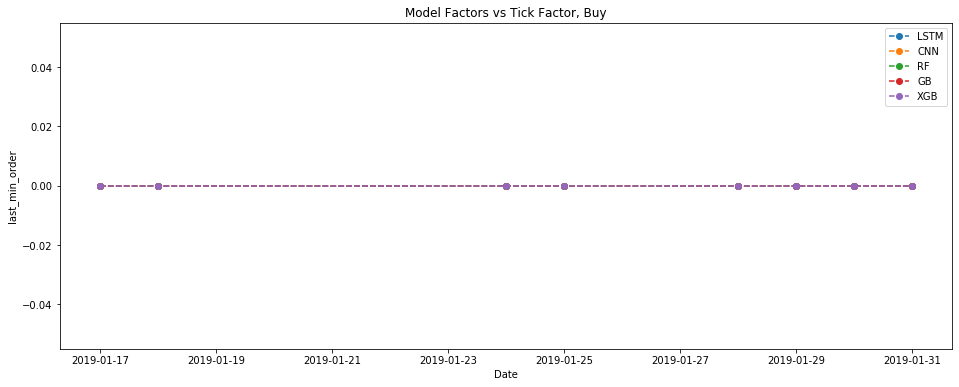

In [25]:
df_compare=pd.DataFrame({"Tick factor":results_tick_b['last_min_order'],
                         "LSTM factor":results_LSTM_b['last_min_order'],
                         "CNN factor":results_CNN_b['last_min_order'],
                         "RandomForest factor":results_RF_b['last_min_order'],
                         "GradientBoost factor":results_GB_b['last_min_order'],
                         "XGBoost factor":results_XGB_b['last_min_order'],
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])
plt.xlabel("Date") 
plt.ylabel('last_min_order')
plt.title("Model Factors vs Tick Factor, Buy")